# 5G Localization

## Read matlab files to dataframes

In [8]:

import concurrent.futures
import os
import time

import numpy as np
import pandas as pd
import tqdm

from scripts.data_loader import load_matlab_file_as_df
from scripts.plotting import make_boxplot
from scripts.utils import compute_metrics, RF_PARAM, extract_unique_npcis
from scripts.weighted_coverage import run_weighted_coverage

# source file
BASE_DIR = "data/"
FULL_DATA_SET = "Campaign_data_NBIoT_1_2_3_4_5_6_interpolated_smoothed.mat"
filename = os.path.join(BASE_DIR, FULL_DATA_SET)
random_seed = 42  # for reproducability

#np.random.seed(random_seed)

# Parameters
rf_param = RF_PARAM.NSINR
operator_choice = np.array([1, 10])
n_runs = 40
k_max = 10

# seed numpy random
np.random.seed(random_seed)

# load the dataset as pandas dataframe
df = load_matlab_file_as_df(
    filename=filename,
    dataset='dataSet_smooth',  # dataSet, dataSet_interp or dataSet_smooth
    usecols=['lat', 'lng', 'measurements_matrix']
)


## Running the weighted coverage strategy

In [9]:

print(f'Running wKNN with max-k = {k_max}, over {n_runs} runs param {rf_param.value}')
# Initialize a list to store the average errors
errors = []
tp_est_locations = []

start_time = time.time()
unique_npcis = extract_unique_npcis(df, operator_choice)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(run_weighted_coverage, df, rf_param, k_max, unique_npcis)
               for n in range(n_runs)]

    for i, future in tqdm.tqdm(enumerate(concurrent.futures.as_completed(futures)), total=n_runs):
        tp_est_location, k_avg_error = future.result()
        errors.append(k_avg_error)
        tp_est_locations.append(tp_est_location)

errors_df = pd.DataFrame(errors)
computed_errors_df = compute_metrics(errors_df)

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Running wKNN with max-k = 10, over 40 runs param NSINR


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]

Execution time: 36.99 seconds


In [10]:
# Compute the average error for each k value across all runs
average_errors = errors_df.mean(axis=0)

# Find the minimum average positioning error and the corresponding k value
min_avg_error = average_errors.min()
best_k = average_errors.idxmin() + 1  # idxmin() returns the index, add 1 to get the k value

print(f"Minimum average positioning error: {min_avg_error} at k={best_k} with rf param {rf_param.value}")

a = average_errors.round(3).apply(str)

res = "\t".join(a)

print(res)

Minimum average positioning error: 0.019315527743351907 at k=3 with rf param NSINR
0.02	0.019	0.02	0.02	0.021	0.022	0.022	0.023	0.024	0.024


## Visualizing the results

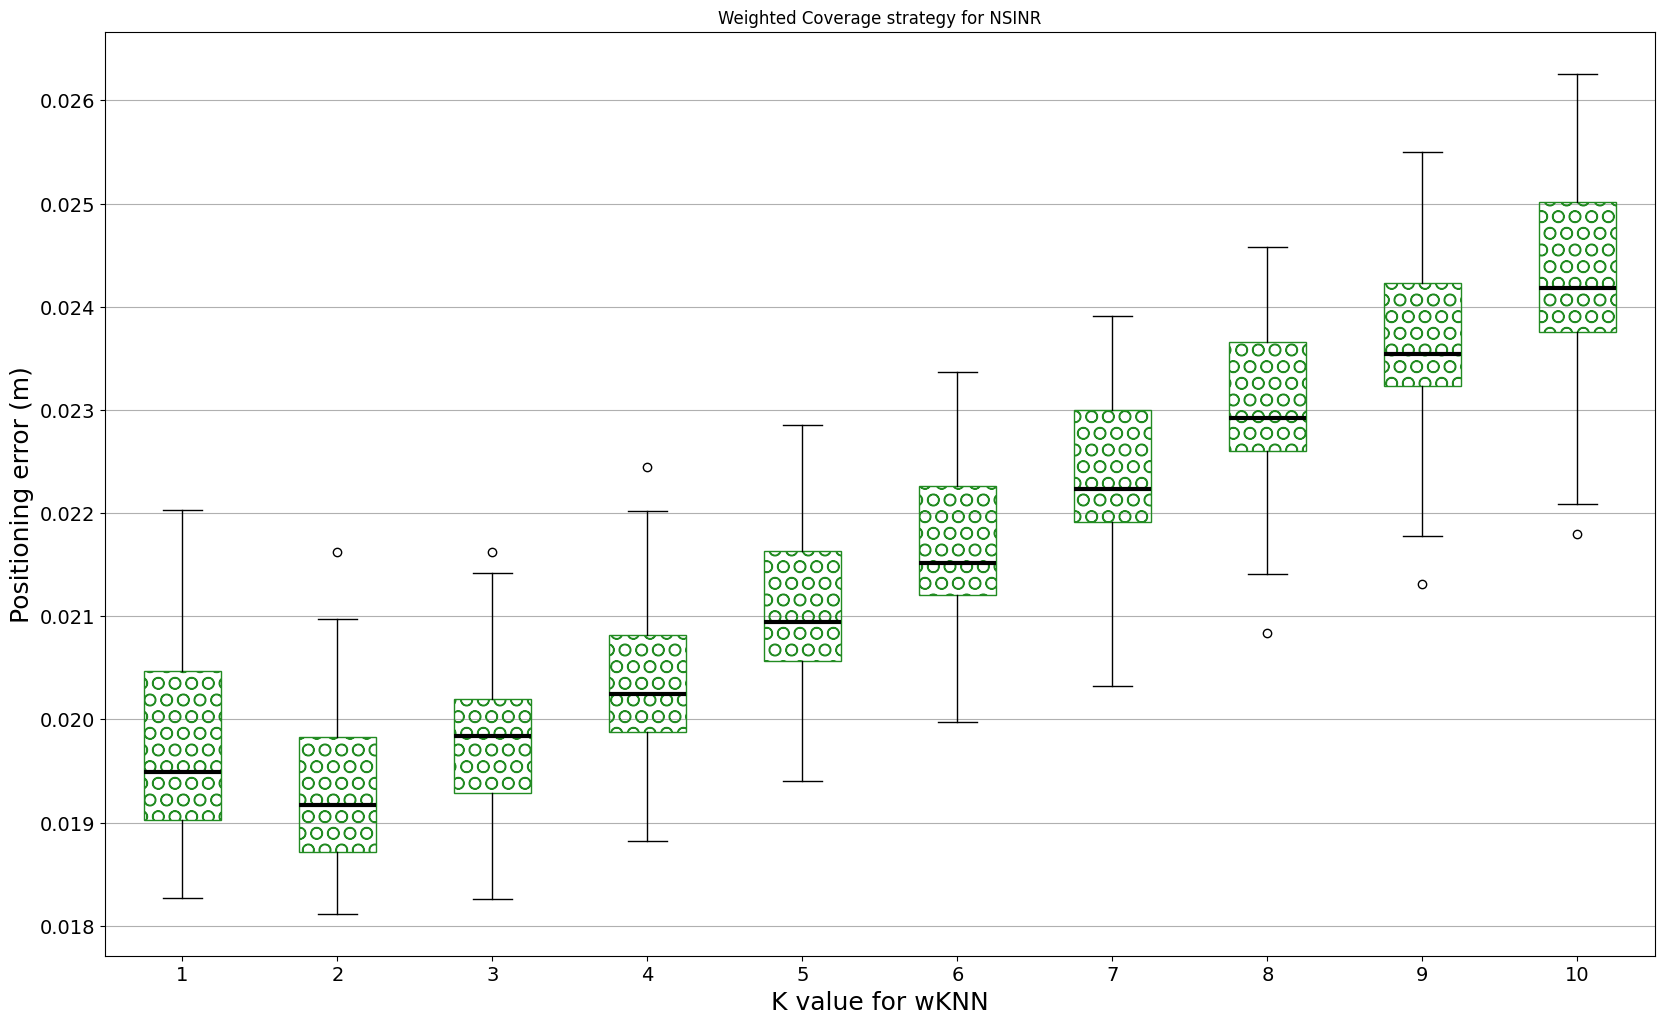

In [11]:
make_boxplot(errors_df, f'Weighted Coverage strategy for {rf_param.value}', 'K value for wKNN', 'Positioning error (m)')

In [12]:
errors_df

,1,2,3,4,5,6,7,8,9,10
0,0.018438,0.018634,0.019332,0.020390,0.021121,0.021600,0.022230,0.022872,0.023248,0.023717
1,0.019788,0.019260,0.019614,0.020001,0.020698,0.021007,0.021897,0.022735,0.023367,0.023981
2,0.020504,0.020275,0.019971,0.020422,0.021004,0.021764,0.022289,0.022481,0.022901,0.023299
3,0.020496,0.019862,0.019905,0.020809,0.021068,0.021781,0.022237,0.023020,0.023776,0.024606
4,0.019271,0.018184,0.018553,0.019207,0.020264,0.021066,0.021915,0.022764,0.023079,0.023844
5,0.018959,0.019076,0.020048,0.020687,0.021825,0.022695,0.023910,0.024427,0.024978,0.025575
6,0.019703,0.018743,0.020089,0.020189,0.020840,0.021431,0.022434,0.023133,0.023758,0.024283
7,0.019336,0.018579,0.018978,0.019752,0.020399,0.021302,0.022037,0.022797,0.023634,0.024213
8,0.019632,0.019012,0.019951,0.020212,0.021143,0.021921,0.022657,0.023217,0.023670,0.024364
9,0.020621,0.020471,0.020860,0.021073,0.021885,0.022784,0.023704,0.024491,0.024872,0.025371


In [13]:
computed_errors_df

,k-value,mean_error,median_error,min_error,max_error,std_dev,mse
0,k=1,0.019702,0.019486,0.018267,0.022027,0.000915,0.000389
1,k=2,0.019316,0.019173,0.018116,0.021618,0.000813,0.000374
2,k=3,0.019789,0.019835,0.018256,0.021624,0.000773,0.000392
3,k=4,0.020362,0.020250,0.018818,0.022448,0.000807,0.000415
4,k=5,0.021011,0.020942,0.019398,0.022849,0.000807,0.000442
5,k=6,0.021698,0.021515,0.019972,0.023369,0.000814,0.000471
6,k=7,0.022385,0.022234,0.020321,0.023910,0.000831,0.000502
7,k=8,0.023075,0.022923,0.020836,0.024576,0.000889,0.000533
8,k=9,0.023661,0.023545,0.021314,0.025495,0.000911,0.000561
9,k=10,0.024275,0.024178,0.021800,0.026258,0.000967,0.000590


In [14]:
computed_errors_df['mean_error'].to_numpy()

array([0.0197016 , 0.01931553, 0.01978887, 0.02036151, 0.02101133,
       0.02169752, 0.02238532, 0.02307467, 0.02366113, 0.02427455])